## Неделя 2. Понедельник-Вторник

### Обучение с учителем

In [1]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score


# tunning hyperparamters model
import optuna

In [2]:
train = pd.read_csv('aux/train.csv')
test = pd.read_csv('aux/test.csv')

submission = pd.read_csv('aux/gender_submission.csv')

In [3]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### 1. Preprocessing (Подготовка данных)

In [4]:
pd.DataFrame(data={'NaN_count': train.isna().sum(), 'data_type':train.dtypes})

,NaN_count,data_type
PassengerId,0,int64
Survived,0,int64
Pclass,0,int64
Name,0,object
Sex,0,object
Age,177,float64
SibSp,0,int64
Parch,0,int64
Ticket,0,object
Fare,0,float64


In [5]:
num_features = train.select_dtypes(exclude='object')
cat_features = train.select_dtypes(include='object')

In [6]:
# Разделим сразу на features и target

X, y = train.drop('Survived', axis=1), train['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

__Pipeline__ - Pipeline(конвейер данных) в машинном обучении представляет собой удобный инструмент для организации последовательности шагов обработки данных и моделирования. Он позволяет объединить несколько этапов обработки данных и моделирования в один объект, что упрощает кодирование и поддержку.

Мы будем работать и создавать общий пайплайн с помощью двух функций в `sklearn`:  
* [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)  (Будет отвечать за параллельные преобразования в данных)
* [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) (Будет отвечать за последовательные преобразования в данных)

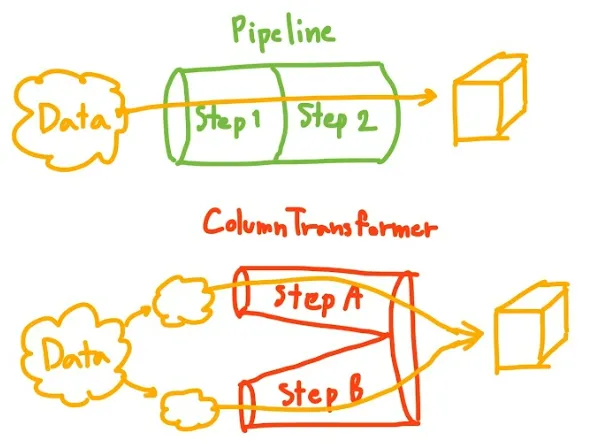

In [7]:
from IPython.display import Image
Image(filename=('aux/piplines_image.jpg'))

#### 1.1 Imputation (Заполнение пропусков) 

In [8]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
359,360,3,"Mockler, Miss. Helen Mary ""Ellie""",female,NaN,0,0,330980,7.8792,NaN,Q
258,259,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
736,737,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.3750,NaN,S
462,463,1,"Gee, Mr. Arthur H",male,47.0,0,0,111320,38.5000,E63,S


In [9]:
drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin'] # Эти столбцы считаем не нужными и выкидываем



my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('num_imputer', SimpleImputer(strategy='mean'), ['Age']), # SimpleImputer Позволяет заполнить каким-либо простым показателем (средним, модой, медианой)
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['Embarked'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)    

In [10]:
filled_data = my_imputer.fit_transform(X_train)

In [11]:
pd.DataFrame(data={'NaN_count': filled_data.isna().sum(), 'data_type':filled_data.dtypes})

,NaN_count,data_type
Age,0,float64
Embarked,0,object
Pclass,0,int64
Sex,0,object
SibSp,0,int64
Parch,0,int64
Fare,0,float64


In [12]:
my_imputer.transform(X_valid).isna().sum()

Age         0
Embarked    0
Pclass      0
Sex         0
SibSp       0
Parch       0
Fare        0
dtype: int64

* [Различные Imputers в sklearn](https://scikit-learn.org/stable/modules/impute.html)

#### 1.2 Ошибочное использование ColumnTransformer

❗❗❗ `ColumnTransformer` нужен именно для параллельного параллельного применения (То есть к разным столбцам).  

Ниже пример, к чему ведет последовательное преобразование (Заполнение NaN и Нормировка) к одному и тому же столбцу.

In [13]:
test_transformer = ColumnTransformer(
    [
        ('Age_imp', SimpleImputer(), ['Age']),
        ('Age_scaler', StandardScaler(), ['Age'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

test_transformer.fit_transform(X_train)

,Age,Age,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked
692,29.807687,NaN,693,3,"Lam, Mr. Ali",male,0,0,1601,56.4958,NaN,S
481,29.807687,NaN,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,0,0,239854,0.0000,NaN,S
527,29.807687,NaN,528,1,"Farthing, Mr. John",male,0,0,PC 17483,221.7792,C95,S
855,18.000000,-0.815864,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,0,1,392091,9.3500,NaN,S
801,31.000000,0.082384,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,1,1,C.A. 31921,26.2500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
359,29.807687,NaN,360,3,"Mockler, Miss. Helen Mary ""Ellie""",female,0,0,330980,7.8792,NaN,Q
258,35.000000,0.358768,259,1,"Ward, Miss. Anna",female,0,0,PC 17755,512.3292,NaN,C
736,48.000000,1.257017,737,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,1,3,W./C. 6608,34.3750,NaN,S
462,47.000000,1.187921,463,1,"Gee, Mr. Arthur H",male,0,0,111320,38.5000,E63,S


Преобразование сделано параллельно, отдельно заполнились NaN, отдельно сделана нормировка. Это не то, что нам нужно

#### 1.3 Encoding and Scaling (Кодирование и нормировка данных)

* Теперь, уже на данных без пропусков последовательно делаем дальнейшее преобразование

In [14]:
ordinal_encoding_columns = ['Sex'] # Столбец, который планируем кодировать порядково, с помощью OrdinalEncoder 
one_hot_encoding_columns = ['Embarked'] # Столбец, который планируем кодировать с помощью OneHotEncoder 

standard_scaler_columns = ['Age', 'Fare'] # Числовые столбцы, которые необходимо пронормировать


scaler_and_encoder = ColumnTransformer(
    [
        ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns),
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

In [15]:
processed_data = scaler_and_encoder.fit_transform(filled_data, y)

In [16]:
processed_data

,Sex,Embarked_C,Embarked_Q,Embarked_S,Age,Fare,Pclass,SibSp,Parch
692,1.0,0.0,0.0,1.0,-5.463229e-16,0.513812,3,0,0
481,1.0,0.0,0.0,1.0,-5.463229e-16,-0.662563,2,0,0
527,1.0,0.0,0.0,1.0,-5.463229e-16,3.955399,1,0,0
855,0.0,0.0,0.0,1.0,-9.078708e-01,-0.467874,3,0,1
801,0.0,0.0,0.0,1.0,9.167471e-02,-0.115977,2,1,1
...,...,...,...,...,...,...,...,...,...
359,0.0,0.0,1.0,0.0,-5.463229e-16,-0.498500,3,0,0
258,0.0,1.0,0.0,0.0,3.992272e-01,10.005329,1,0,0
736,0.0,0.0,0.0,1.0,1.398773e+00,0.053205,3,1,3
462,1.0,0.0,0.0,1.0,1.321885e+00,0.139097,1,0,0


In [17]:
pd.DataFrame(data={'NaN_count': processed_data.isna().sum(), 'data_type':processed_data.dtypes})

,NaN_count,data_type
Sex,0,float64
Embarked_C,0,float64
Embarked_Q,0,float64
Embarked_S,0,float64
Age,0,float64
Fare,0,float64
Pclass,0,int64
SibSp,0,int64
Parch,0,int64


#### 1.4 total Preprocessor

* Создадим общий препроцессор `preprocessor`, Как объединение нашего `imputer`(1.1), `scaler_and_encoder`(1.3)

In [18]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [19]:
preprocessor.fit_transform(X_train) # Обучаем весь препроцессинг и сразу же трансформируем наши входные данные

,Sex,Embarked_C,Embarked_Q,Embarked_S,Age,Fare,Pclass,SibSp,Parch
692,1.0,0.0,0.0,1.0,-5.463229e-16,0.513812,3,0,0
481,1.0,0.0,0.0,1.0,-5.463229e-16,-0.662563,2,0,0
527,1.0,0.0,0.0,1.0,-5.463229e-16,3.955399,1,0,0
855,0.0,0.0,0.0,1.0,-9.078708e-01,-0.467874,3,0,1
801,0.0,0.0,0.0,1.0,9.167471e-02,-0.115977,2,1,1
...,...,...,...,...,...,...,...,...,...
359,0.0,0.0,1.0,0.0,-5.463229e-16,-0.498500,3,0,0
258,0.0,1.0,0.0,0.0,3.992272e-01,10.005329,1,0,0
736,0.0,0.0,0.0,1.0,1.398773e+00,0.053205,3,1,3
462,1.0,0.0,0.0,1.0,1.321885e+00,0.139097,1,0,0


In [20]:
preprocessor.transform(X_valid) # Трансформируем другие данные, которые алгоритм еще не видел!

,Sex,Embarked_C,Embarked_Q,Embarked_S,Age,Fare,Pclass,SibSp,Parch
565,1.0,0.0,0.0,1.0,-4.465421e-01,-0.159704,3,2,0
160,1.0,0.0,0.0,1.0,1.091220e+00,-0.327324,3,0,1
553,1.0,1.0,0.0,0.0,-6.003184e-01,-0.512122,3,0,0
860,1.0,0.0,0.0,1.0,8.605559e-01,-0.368795,3,2,0
241,0.0,0.0,1.0,0.0,-5.463229e-16,-0.339817,3,1,0
...,...,...,...,...,...,...,...,...,...
880,0.0,0.0,0.0,1.0,-3.696540e-01,-0.121182,2,0,1
91,1.0,0.0,0.0,1.0,-7.540946e-01,-0.499020,3,0,0
883,1.0,0.0,0.0,1.0,-1.389896e-01,-0.443929,2,0,0
473,0.0,1.0,0.0,0.0,-5.234302e-01,-0.375388,2,0,0


### 2. ML-модели

#### 2.1 LogisticRegression

In [21]:
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', LogisticRegression())
    ]
)

In [22]:
ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop_features',
                                                                   'drop',
                                                                   ['PassengerId',
                                                                    'Name',
                                                                    'Ticket',
                                                                    'Cabin']),
                                                                  ('num_imputer',
                                                                   SimpleImputer(),
                                                                   ['Age']),
                                                                  ('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['Embarked'])],
                                                    verbose_feature_names_out=False)),
                                 ('scaler_and_encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ordinal_encoding',
                                                                   OrdinalEncoder(),
                                                                   ['Sex']),
                                                                  ('one_hot_encoding_columns',
                                                                   OneHotEncoder(sparse_output=False),
                                                                   ['Embarked']),
                                                                  ('scaling_num_columns',
                                                                   StandardScaler(),
                                                                   ['Age',
                                                                    'Fare'])],
                                                    verbose_feature_names_out=False))])),
                ('model', LogisticRegression())])

In [23]:
print('train accuracy:', accuracy_score(y_train, ml_pipeline.predict(X_train))) # Доля правильных ответов на выборке, которая была использована для обучения
print('valid accuracy:', accuracy_score(y_valid, ml_pipeline.predict(X_valid))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

train accuracy: 0.8061797752808989
valid accuracy: 0.7988826815642458


In [24]:
coeffs = np.round(ml_pipeline['model'].coef_[0], 3)
features = list(preprocessor.transform(X_train).columns)

In [25]:
pd.DataFrame(data={'weight': coeffs}, index=features).sort_values(by='weight', key=lambda x: abs(x), ascending=False)

,weight
Sex,-2.556
Pclass,-1.092
Age,-0.504
Embarked_S,-0.361
Embarked_Q,0.329
SibSp,-0.245
Fare,0.104
Parch,-0.074
Embarked_C,0.033


In [26]:
equation_terms = [f"({coef} * {col})" for coef, col in zip(coeffs, features)]
equation_string = " + ".join(equation_terms)

print(f'y = {equation_string}')

y = (-2.556 * Sex) + (0.033 * Embarked_C) + (0.329 * Embarked_Q) + (-0.361 * Embarked_S) + (-0.504 * Age) + (0.104 * Fare) + (-1.092 * Pclass) + (-0.245 * SibSp) + (-0.074 * Parch)


* __Особенно важными признаками окзались `Sex`, `Pclass`, `Age`__. 

#### 2.2 KNNClassifier

In [27]:
model = KNeighborsClassifier(n_neighbors=15, p=1, weights='uniform')

ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

In [28]:
ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop_features',
                                                                   'drop',
                                                                   ['PassengerId',
                                                                    'Name',
                                                                    'Ticket',
                                                                    'Cabin']),
                                                                  ('num_imputer',
                                                                   SimpleImputer(),
                                                                   ['Age']),
                                                                  ('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['Embarked'])],
                                                    verbose_feature_names_out=False)),
                                 ('scaler_and_encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ordinal_encoding',
                                                                   OrdinalEncoder(),
                                                                   ['Sex']),
                                                                  ('one_hot_encoding_columns',
                                                                   OneHotEncoder(sparse_output=False),
                                                                   ['Embarked']),
                                                                  ('scaling_num_columns',
                                                                   StandardScaler(),
                                                                   ['Age',
                                                                    'Fare'])],
                                                    verbose_feature_names_out=False))])),
                ('model', KNeighborsClassifier(n_neighbors=15, p=1))])

In [29]:
print('train accuracy:', accuracy_score(y_train, ml_pipeline.predict(X_train))) # Доля правильных ответов на выборке, которая была использована для обучения
print('valid accuracy:', accuracy_score(y_valid, ml_pipeline.predict(X_valid))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

train accuracy: 0.8398876404494382
valid accuracy: 0.8044692737430168


#### 2.3 DecisionTreeClassifier

In [30]:
model = DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_split=3)

ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

In [31]:
ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop_features',
                                                                   'drop',
                                                                   ['PassengerId',
                                                                    'Name',
                                                                    'Ticket',
                                                                    'Cabin']),
                                                                  ('num_imputer',
                                                                   SimpleImputer(),
                                                                   ['Age']),
                                                                  ('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['Embarked'])],
                                                    verbose_feature_names_out=False)),
                                 ('scaler_and_encoder',
                                  Colu...sformer(remainder='passthrough',
                                                    transformers=[('ordinal_encoding',
                                                                   OrdinalEncoder(),
                                                                   ['Sex']),
                                                                  ('one_hot_encoding_columns',
                                                                   OneHotEncoder(sparse_output=False),
                                                                   ['Embarked']),
                                                                  ('scaling_num_columns',
                                                                   StandardScaler(),
                                                                   ['Age',
                                                                    'Fare'])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        min_samples_split=3))])

In [32]:
print('train accuracy:', accuracy_score(y_train, ml_pipeline.predict(X_train))) # Доля правильных ответов на выборке, которая была использована для обучения
print('valid accuracy:', accuracy_score(y_valid, ml_pipeline.predict(X_valid))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

train accuracy: 0.8258426966292135
valid accuracy: 0.8044692737430168


### 3. Собственные пайплайны CustomPipelines

* Возможно необходимо по-своему закодировать, заполнить прпоуски и т.д
* Создать новые фичи(`feature_engineering`), или просто сделать какие-то преобразования(прологарифмировать столбец и т.д.)

In [33]:
X.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [34]:
X.groupby('Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

1. Заполним NaN в `Age` исходя из `Pclass` пассажира. Так как средний возраст по классам различается  
2. `SibSp`, `Parch` соединим воедино, просто назовем это  `number_of_family_members`

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

# Создание своего Imputer'а
class AgeImputer(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None): # Запутстится в момент, когда будет вызван у всего pipeline метод .fit()
        self.params_ = X.groupby('Pclass')['Age'].mean().to_dict() # Сохраним в атрибуте экземпляра средние значения возраста по классам
        return self # метод .fit всегда должен возвращать сам экземпляр
    def transform(self, X, y=None): # Запустится тогда, когда нужно будет отдать результат на следующий шаг
        X_copy = X.copy()
        X_copy['Age'] = X_copy['Age'].fillna(X['Pclass'].map(self.params_))
        return X_copy[['Pclass', 'Age']]
    

# Создание своего преобразователя
class FamiliyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy['number_of_family_members'] = X_copy['SibSp'] + X_copy['Parch']
        X_copy.drop(['SibSp', 'Parch'], axis=1, inplace=True)
        return X_copy

In [36]:
# DROP
DROP_FEATURES = ['PassengerId', 'Name', 'Ticket', 'Cabin'] # Эти столбцы считаем не нужными и выкидываем

# IMPUTE
AGE_IMPUTE_FEATURES = ['Pclass', 'Age'] # Pclass нужен для заполнения Age 
EMBARKED_IMPUTE_FEATURES = ['Embarked']

# ENCODING
ORDINAL_ENCODING_FEATURES = ['Sex']
ONE_HOT_FEATURES = ['Embarked']

# SCALING
STANDARD_SCALER_FEATURES = ['Age', 'Fare']

#FEATURE_ENGINEERING
NUMBER_OF_FAMILIY_MEMBER_FEATURES = ['SibSp', 'Parch']

In [37]:
my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', DROP_FEATURES),
        ('age_imputer', AgeImputer(), AGE_IMPUTE_FEATURES),
        ('fare_imputer', SimpleImputer(strategy='mean'), ['Fare']),
        ('embarked_imputer', SimpleImputer(strategy='most_frequent'), EMBARKED_IMPUTE_FEATURES)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)    

scaler_and_encoder = ColumnTransformer(
    [
        ('ordinal_encoding_features', OrdinalEncoder(), ordinal_encoding_columns),
        ('one_hot_encoding_features', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_features', StandardScaler(), standard_scaler_columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

In [38]:
ml_pipeline = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('feature_generator', FamiliyTransformer()),
        ('model', DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_split=3))
    ]
)

In [39]:
ml_pipeline

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket', 'Cabin']),
                                                 ('age_imputer', AgeImputer(),
                                                  ['Pclass', 'Age']),
                                                 ('fare_imputer',
                                                  SimpleImputer(), ['Fare']),
                                                 ('embarked_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('sca...
                                   transformers=[('ordinal_encoding_features',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('one_hot_encoding_features',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Embarked']),
                                                 ('scaling_num_features',
                                                  StandardScaler(),
                                                  ['Age', 'Fare'])],
                                   verbose_feature_names_out=False)),
                ('feature_generator', FamiliyTransformer()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        min_samples_split=3))])

In [40]:
ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket', 'Cabin']),
                                                 ('age_imputer', AgeImputer(),
                                                  ['Pclass', 'Age']),
                                                 ('fare_imputer',
                                                  SimpleImputer(), ['Fare']),
                                                 ('embarked_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('sca...
                                   transformers=[('ordinal_encoding_features',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('one_hot_encoding_features',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Embarked']),
                                                 ('scaling_num_features',
                                                  StandardScaler(),
                                                  ['Age', 'Fare'])],
                                   verbose_feature_names_out=False)),
                ('feature_generator', FamiliyTransformer()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        min_samples_split=3))])

In [41]:
print('train accuracy:', accuracy_score(y_train, ml_pipeline.predict(X_train))) # Доля правильных ответов на выборке, которая была использована для обучения
print('valid accuracy:', accuracy_score(y_valid, ml_pipeline.predict(X_valid))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

train accuracy: 0.8286516853932584
valid accuracy: 0.8044692737430168


### 4. Cross Validation

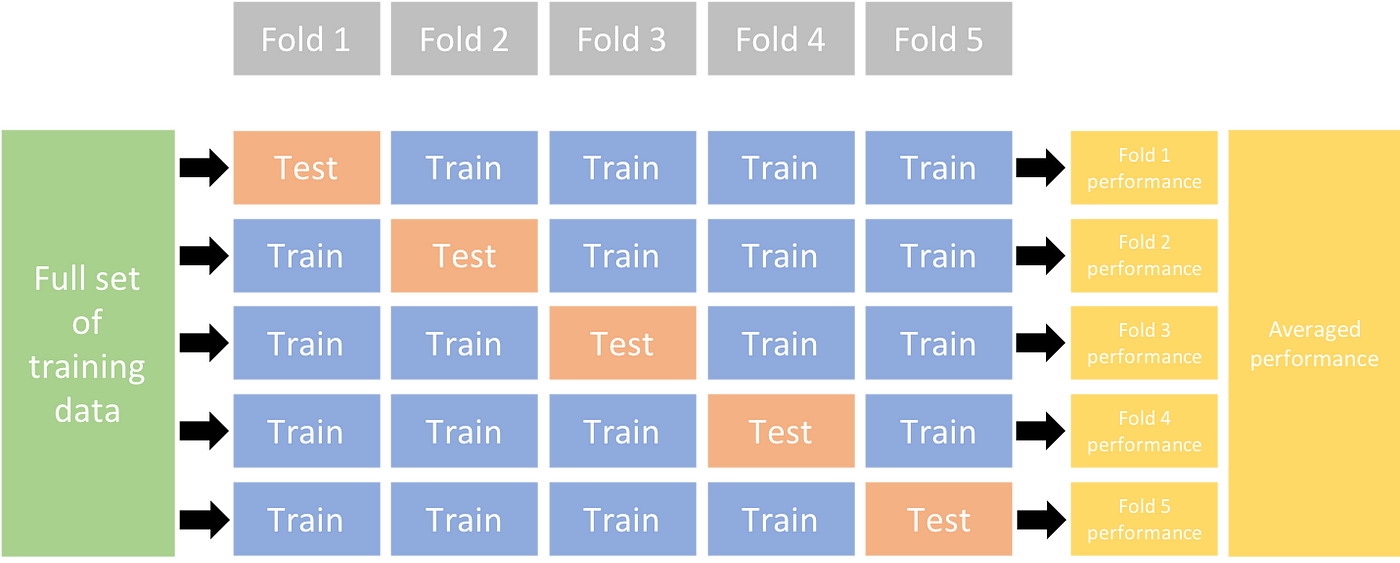

In [42]:
Image(filename=('aux/cross_validation.png'))

In [43]:
cv = KFold(n_splits=5, random_state=666, shuffle=True)

cross_validation_result = cross_val_score(
    ml_pipeline,
    X, # Подаем датасет целиком!!! Разделение на train и valid происходит внутри
    y,
    cv = cv
)

# cross_validation_result
cross_validation_result.mean()

0.8125855250768941

### 5. Optuna hyperparameter tuning

In [44]:
ml_pipeline.named_steps # Здесь можно увидеть все составляеющие нашего Pipeline 

{'imputer': ColumnTransformer(remainder='passthrough',
                   transformers=[('drop_features', 'drop',
                                  ['PassengerId', 'Name', 'Ticket', 'Cabin']),
                                 ('age_imputer', AgeImputer(),
                                  ['Pclass', 'Age']),
                                 ('fare_imputer', SimpleImputer(), ['Fare']),
                                 ('embarked_imputer',
                                  SimpleImputer(strategy='most_frequent'),
                                  ['Embarked'])],
                   verbose_feature_names_out=False),
 'scaler_and_encoder': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinal_encoding_features', OrdinalEncoder(),
                                  ['Sex']),
                                 ('one_hot_encoding_features',
                                  OneHotEncoder(sparse_output=False),
                                  ['Embarked']),
       

* более подробно про `optuna`: [optuna documentation](https://optuna.org/#code_examples)

In [45]:
def objective(trial):
    
    # Параметры самой модели
    model_params = {
        'max_depth' : trial.suggest_int('max_depth', 2, 10, 1),
        'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
    }
    
    
    ml_pipeline.named_steps['model'].set_params(**model_params)
    #model = ml_pipeline.set_params(**params)
    
    
    
    # Можно добавить выбор encoder'а
    encoder_type_label = trial.suggest_categorical('encoder_type', ['OneHotEnc', 'TargetEnc'])
    encoder_mapping = {'OneHotEnc': OneHotEncoder(sparse_output=False), 'TargetEnc': TargetEncoder()}
    
    
    ml_pipeline.named_steps['scaler_and_encoder'].set_params(
        one_hot_encoding_features=encoder_mapping[encoder_type_label]
    )
        
    # Создание сплитов для кросс-валидации
    cv = KFold(n_splits=5, random_state=666, shuffle=True)

    # Вычисление метрик точности с использованием кросс-валидации
    scores = cross_val_score(ml_pipeline, X, y, cv=cv)
    
    accuracy = scores.mean()
    
    return accuracy


# Создание объекта для проведения оптимизации
study = optuna.create_study(direction='maximize')


# Запуск оптимизации
study.optimize(objective, n_trials=100)


# Вывод результатов
best_params = study.best_params
best_value = study.best_value


print(f"Лучшие параметры: {best_params}")
print(f"Лучшее значение: {best_value}")

[I 2023-12-04 00:46:43,534] A new study created in memory with name: no-name-fcd4c644-d38c-408e-a002-d2bf8fedfc32
[I 2023-12-04 00:46:43,667] Trial 0 finished with value: 0.7845081915761722 and parameters: {'max_depth': 9, 'criterion': 'gini', 'encoder_type': 'OneHotEnc'}. Best is trial 0 with value: 0.7845081915761722.
[I 2023-12-04 00:46:43,798] Trial 1 finished with value: 0.7923545289059067 and parameters: {'max_depth': 10, 'criterion': 'gini', 'encoder_type': 'TargetEnc'}. Best is trial 1 with value: 0.7923545289059067.
[I 2023-12-04 00:46:43,920] Trial 2 finished with value: 0.8125855250768941 and parameters: {'max_depth': 3, 'criterion': 'log_loss', 'encoder_type': 'TargetEnc'}. Best is trial 2 with value: 0.8125855250768941.
[I 2023-12-04 00:46:44,048] Trial 3 finished with value: 0.7845081915761722 and parameters: {'max_depth': 9, 'criterion': 'entropy', 'encoder_type': 'TargetEnc'}. Best is trial 2 with value: 0.8125855250768941.
[I 2023-12-04 00:46:44,169] Trial 4 finished w

Лучшие параметры: {'max_depth': 5, 'criterion': 'gini', 'encoder_type': 'OneHotEnc'}
Лучшее значение: 0.8215491808423827


#### 6. Ensemble models

#### 6.1 Voting

In [46]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=2, criterion='gini', random_state=42)
knn = KNeighborsClassifier(n_neighbors=10, p=2, weights='distance')

vc = VotingClassifier(
    [
        ('LogReg', lr),
        ('DecisionTree', dt),
        ('KNeighbors', knn)
    ]
)

In [47]:
ml_pipeline = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('feature_generator', FamiliyTransformer()),
        ('model', vc)
    ]
)
ml_pipeline

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket', 'Cabin']),
                                                 ('age_imputer', AgeImputer(),
                                                  ['Pclass', 'Age']),
                                                 ('fare_imputer',
                                                  SimpleImputer(), ['Fare']),
                                                 ('embarked_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('sca...
                                                  ['Embarked']),
                                                 ('scaling_num_features',
                                                  StandardScaler(),
                                                  ['Age', 'Fare'])],
                                   verbose_feature_names_out=False)),
                ('feature_generator', FamiliyTransformer()),
                ('model',
                 VotingClassifier(estimators=[('LogReg', LogisticRegression()),
                                              ('DecisionTree',
                                               DecisionTreeClassifier(max_depth=2,
                                                                      random_state=42)),
                                              ('KNeighbors',
                                               KNeighborsClassifier(n_neighbors=10,
                                                                    weights='distance'))]))])

In [48]:
ml_pipeline.fit(X_train, y_train)

print('train accuracy:', accuracy_score(y_train, ml_pipeline.predict(X_train))) # Доля правильных ответов на выборке, которая была использована для обучения
print('valid accuracy:', accuracy_score(y_valid, ml_pipeline.predict(X_valid))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

train accuracy: 0.8946629213483146
valid accuracy: 0.8156424581005587


In [49]:
cv = KFold(n_splits=5, random_state=666, shuffle=True)

cross_validation_result = cross_val_score(
    ml_pipeline, 
    X,
    y,
    cv=KFold(n_splits=5, random_state=666, shuffle=True)
)

cross_validation_result.mean()

0.8114305442219573

In [50]:
# ml_pipeline.predict(test)

#### 6.2 Bagging

##### 6.2.1 BaggingClassifier

In [51]:
bc = BaggingClassifier(
    estimator = KNeighborsClassifier(n_neighbors=15, p=2, weights='uniform'),
    n_estimators=20
)

ml_pipeline = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('feature_generator', FamiliyTransformer()),
        ('model', bc)
    ]
)

ml_pipeline

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket', 'Cabin']),
                                                 ('age_imputer', AgeImputer(),
                                                  ['Pclass', 'Age']),
                                                 ('fare_imputer',
                                                  SimpleImputer(), ['Fare']),
                                                 ('embarked_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('sca...
                                   transformers=[('ordinal_encoding_features',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('one_hot_encoding_features',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Embarked']),
                                                 ('scaling_num_features',
                                                  StandardScaler(),
                                                  ['Age', 'Fare'])],
                                   verbose_feature_names_out=False)),
                ('feature_generator', FamiliyTransformer()),
                ('model',
                 BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=15),
                                   n_estimators=20))])

In [52]:
ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket', 'Cabin']),
                                                 ('age_imputer', AgeImputer(),
                                                  ['Pclass', 'Age']),
                                                 ('fare_imputer',
                                                  SimpleImputer(), ['Fare']),
                                                 ('embarked_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('sca...
                                   transformers=[('ordinal_encoding_features',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('one_hot_encoding_features',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Embarked']),
                                                 ('scaling_num_features',
                                                  StandardScaler(),
                                                  ['Age', 'Fare'])],
                                   verbose_feature_names_out=False)),
                ('feature_generator', FamiliyTransformer()),
                ('model',
                 BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=15),
                                   n_estimators=20))])

In [53]:
print('train accuracy:', accuracy_score(y_train, ml_pipeline.predict(X_train))) # Доля правильных ответов на выборке, которая была использована для обучения
print('valid accuracy:', accuracy_score(y_valid, ml_pipeline.predict(X_valid))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

train accuracy: 0.8286516853932584
valid accuracy: 0.7877094972067039


##### 6.2.2 RandomForestClassifier

In [54]:
rf = RandomForestClassifier(n_estimators=30, random_state=1)

ml_pipeline = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('feature_generator', FamiliyTransformer()),
        ('model', rf)
    ]
)

ml_pipeline

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket', 'Cabin']),
                                                 ('age_imputer', AgeImputer(),
                                                  ['Pclass', 'Age']),
                                                 ('fare_imputer',
                                                  SimpleImputer(), ['Fare']),
                                                 ('embarked_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('sca...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoding_features',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('one_hot_encoding_features',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Embarked']),
                                                 ('scaling_num_features',
                                                  StandardScaler(),
                                                  ['Age', 'Fare'])],
                                   verbose_feature_names_out=False)),
                ('feature_generator', FamiliyTransformer()),
                ('model',
                 RandomForestClassifier(n_estimators=30, random_state=1))])

In [55]:
ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket', 'Cabin']),
                                                 ('age_imputer', AgeImputer(),
                                                  ['Pclass', 'Age']),
                                                 ('fare_imputer',
                                                  SimpleImputer(), ['Fare']),
                                                 ('embarked_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('sca...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoding_features',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('one_hot_encoding_features',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Embarked']),
                                                 ('scaling_num_features',
                                                  StandardScaler(),
                                                  ['Age', 'Fare'])],
                                   verbose_feature_names_out=False)),
                ('feature_generator', FamiliyTransformer()),
                ('model',
                 RandomForestClassifier(n_estimators=30, random_state=1))])

In [56]:
print('train accuracy:', accuracy_score(y_train, ml_pipeline.predict(X_train))) # Доля правильных ответов на выборке, которая была использована для обучения
print('valid accuracy:', accuracy_score(y_valid, ml_pipeline.predict(X_valid))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

train accuracy: 0.9803370786516854
valid accuracy: 0.8212290502793296


#### 6.3 Boosting

In [57]:
from catboost import CatBoostClassifier

In [58]:
preprocessor.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket', 'Cabin']),
                                                 ('num_imputer',
                                                  SimpleImputer(), ['Age']),
                                                 ('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('scaler_and_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoding',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('one_hot_encoding_columns',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Embarked']),
                                                 ('scaling_num_columns',
                                                  StandardScaler(),
                                                  ['Age', 'Fare'])],
                                   verbose_feature_names_out=False))])

In [59]:
preprocessed_X_train = preprocessor.transform(X_train)
preprocessed_X_valid = preprocessor.transform(X_valid)

In [60]:
cb = CatBoostClassifier(eval_metric='Accuracy')

cb.fit(
    preprocessed_X_train,
    y_train,
    eval_set=(preprocessed_X_valid, y_valid),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.029139
0:	learn: 0.8412921	test: 0.7988827	best: 0.7988827 (0)	total: 77.9ms	remaining: 1m 17s
1:	learn: 0.8426966	test: 0.8212291	best: 0.8212291 (1)	total: 79.2ms	remaining: 39.5s
2:	learn: 0.8342697	test: 0.8324022	best: 0.8324022 (2)	total: 80ms	remaining: 26.6s
3:	learn: 0.8342697	test: 0.8324022	best: 0.8324022 (2)	total: 80.8ms	remaining: 20.1s
4:	learn: 0.8342697	test: 0.8324022	best: 0.8324022 (2)	total: 82.6ms	remaining: 16.4s
5:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (2)	total: 89.6ms	remaining: 14.8s
6:	learn: 0.8356742	test: 0.8156425	best: 0.8324022 (2)	total: 91.4ms	remaining: 13s
7:	learn: 0.8398876	test: 0.8212291	best: 0.8324022 (2)	total: 92.3ms	remaining: 11.5s
8:	learn: 0.8328652	test: 0.8212291	best: 0.8324022 (2)	total: 93.3ms	remaining: 10.3s
9:	learn: 0.8342697	test: 0.8156425	best: 0.8324022 (2)	total: 94.2ms	remaining: 9.32s
10:	learn: 0.8342697	test: 0.8156425	best: 0.8324022 (2)	total: 95.1ms	remaining: 8.55s
11:	learn: 0.83

In [61]:
print('train accuracy:', accuracy_score(y_train, cb.predict(preprocessed_X_train))) # Доля правильных ответов на выборке, которая была использована для обучения
print('valid accuracy:', accuracy_score(y_valid, cb.predict(preprocessed_X_valid))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

train accuracy: 0.8342696629213483
valid accuracy: 0.8324022346368715


In [62]:
preprocessed_test = preprocessor.transform(test)

In [63]:
cb.predict(preprocessed_test)

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [64]:
cb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Accuracy',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.02913900

#### 7. Save model

* Для деплоя модели, необходимо ее сохранить
* Это позволит нам давать предсказания на стороне приложения
* назовем этот файл c нашим приложением `app.py`

In [65]:
ml_pipeline

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket', 'Cabin']),
                                                 ('age_imputer', AgeImputer(),
                                                  ['Pclass', 'Age']),
                                                 ('fare_imputer',
                                                  SimpleImputer(), ['Fare']),
                                                 ('embarked_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Embarked'])],
                                   verbose_feature_names_out=False)),
                ('sca...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoding_features',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('one_hot_encoding_features',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Embarked']),
                                                 ('scaling_num_features',
                                                  StandardScaler(),
                                                  ['Age', 'Fare'])],
                                   verbose_feature_names_out=False)),
                ('feature_generator', FamiliyTransformer()),
                ('model',
                 RandomForestClassifier(n_estimators=30, random_state=1))])

❗ Если в вашем `Pipeline` есть кастомные преобразования(которых нет в готовом виде sklearn) их необходимо вынести в отдельный файл, для правильной подгрузки и развертки модели на стороне приложения

* В моем случае, таковые есть - `AgeImputer`, `FamilyTransformer`
* Создаю файл `custom_transformers.py` и переношу их туда

In [66]:
import joblib

In [68]:
joblib.dump(ml_pipeline, 'aux/ml_pipeline.pkl')

['aux/ml_pipeline.pkl']